In [1]:
import sys
sys.path.append('../src')

In [2]:
from gso.manifolds import AlgebraicManifold, plot_manifold
from gso.graph_sampling import GraphSampler
from gso.signal_generation import SignalGenerator

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.linalg import pinvh

## Algebraic Manifold

In [4]:
num_equations = 2
num_variables = 4
max_degree = 4
seed = 22

M = AlgebraicManifold(num_equations, num_variables, max_degree, seed)

print(M)
print(M.intrinsic_dim)
print(M.get_equations())
print(M.get_jacobian())

AlgebraicManifold(num_equations=2, num_variables=4, max_degree=4, random_seed=22)
2
[-0.583078925282315*x0 + 0.461013293572337*x1**3 + 0.718363997042688*x2 + 0.693417971415281*x3, -0.458934333404338*x0**3 - 0.9772068378269*x1 + 0.623901841077373*x2**4 - 0.692700720411484*x3**4]
Matrix([[-0.583078925282315, 1.38303988071701*x1**2, 0.718363997042688, 0.693417971415281], [-1.37680300021301*x0**2, -0.977206837826900, 2.49560736430949*x2**3, -2.77080288164594*x3**3]])


In [5]:
# plot_manifold(M.equations, M.variables)

## Point Sampling

Uniform sampling is required for $L\to\Delta_\mathcal{M}$. Non-uniform sampling would converge to a weighted Laplace-Beltrami operator:
$$
\Delta_\rho f=\Delta_\mathcal{M}f+\frac{\nabla\rho}{\rho}\cdot \nabla f
$$
where $\rho$ is the sampling density. We use random affine slicing to avoid ambient space bias, which produces samples with density proportional to the Riemannian measure.

In [6]:
start_time = time.perf_counter()
point_cloud = M.sample(99)
elapsed = time.perf_counter() - start_time

print(f"Function took {elapsed:.4f} seconds")

print(len(point_cloud))
for x in point_cloud:
    assert M._is_valid_point(x, domain = (-2.0, 2.0), tol = 1e-6)

Function took 0.0703 seconds
99


In [7]:
start_time = time.perf_counter()
D = M.compute_geodesics(point_cloud)
elapsed = time.perf_counter() - start_time

print(f"Function took {elapsed:.4f} seconds")


print("First 5x5 geodesic distances:")
print(D[:5, :5])

Function took 0.0386 seconds
First 5x5 geodesic distances:
[[0.         0.32667325 0.0184099  0.25905891 0.02414391]
 [0.32667325 0.         0.14084002 0.87747811 0.35613729]
 [0.0184099  0.14084002 0.         0.43516537 0.00176604]
 [0.25905891 0.87747811 0.43516537 0.         0.58824391]
 [0.02414391 0.35613729 0.00176604 0.58824391 0.        ]]


In [8]:
def visualize_matrix(matrix, n: int = 100, figsize = (5, 4), title = None) -> None:
    """
    Visualize weighted matrices as a square heatmap of size n by n.
        
    Args:
        n: Number of points to include in the visualization
    """
    n = min(n, matrix.shape[0])
    
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(matrix[:n, :n], square=True, annot=False, cmap='viridis', ax=ax)
    if title is not None:
        ax.set_title(title)
    plt.show()

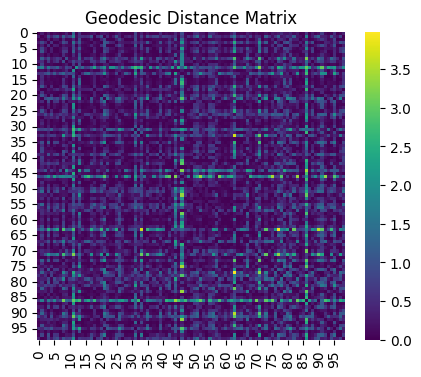

In [9]:
visualize_matrix(D, title='Geodesic Distance Matrix')

In [10]:
# plot_manifold(M.equations, M.variables, points=point_cloud)

## Graph Generator

Create a graph structure (sparse matrix: csr_matrix), e.g. from SBM model. Then create a weighted graph based on the structure and a manifold. 

The graph Laplacian $L$ approximates the generator of heat diffusion on the manifold $\mathcal{M}$. For a smooth function $f$ on $\mathcal{M}$:

$$
-c_n L f \approx \Delta_{\mathcal{M}} f
$$

where $c_n = \epsilon^{-(d/2 + 1)}$ scales the Laplacian to match the continuous operator. This links discrete graph dynamics to the PDE:

$$
\frac{\partial u}{\partial t} = \Delta_{\mathcal{M}} u
$$

governing heat flow on $\mathcal{M}$.

The Gaussian kernel $W_{ij} = \exp(-||x_i -x_j||^2/\epsilon)$ approximates the **manifold heat kernel**:

$$
G_\epsilon(x,y) \propto \epsilon^{-d/2} \exp\left(-\frac{d_\mathcal{M}(x,y)^2}{4\epsilon}\right)
$$

where $d_\mathcal{M}$ is the geodesic distance. This ensures spectral convergence of $-c_n L$ to $\Delta_{\mathcal{M}}$ as $n \to \infty$.

For $L \to \Delta_{\mathcal{M}}$, three conditions must hold:

| Condition | Mathematical Requirement | Purpose |
|-----------|---------------------------|---------|
| Bandwidth decay | $\epsilon(n) \sim \left(\frac{\log n}{n}\right)^{\frac{2}{d+2}}$ | Balances locality vs connectivity |
| Kernel normalization | $c_n = \epsilon^{-(d/2 + 1)}$ | Compensates for kernel decay |
| Sparsity | $\text{avg degree} \sim \log n$ | Avoids overconnection |

The critical rates ensure:
$$
\sup_{x_i} | -c_n L f(x_i) - \Delta_{\mathcal{M}} f(x_i) | \xrightarrow{n \to \infty} 0
$$

**1. Bandwidth Calculation**

$$
\epsilon = C_M \left( \frac{\log n}{n} \right)^{\frac{2}{d + 2}}
$$

- $C_M$: Manifold curvature constant
- Derived from eigen-convergence rate optimization

**2. Weight Assignment**

For edge $(i,j)$ in sparse adjacency $S$:
$$
W_{ij} = \exp\left(-\frac{||x_i -x_j||^2}{\epsilon}\right) \cdot S_{ij}
$$

**3. Implementation Steps**

1. Sample $\{x_i\} \subset \mathcal{M}$ uniformly
2. Compute pairwise distances for edges in $S$
3. Set $\epsilon$ via above formula
4. Construct $W$ using Gaussian kernel
5. Form $L = D - W$ and scale by $c_n$

This workflow guarantees spectral convergence to the Laplace-Beltrami operator.

In [11]:
import networkx as nx
from scipy.sparse import csr_matrix

def create_sbm(sizes: list, probs: list, seed=None) -> csr_matrix:
    """
    Generate SBM graph as compressed sparse row matrix.
    
    Parameters:
    sizes : list of ints        # Nodes per community
    probs : 2D list of floats   # Inter/intra-community edge probabilities
    seed  : int (optional)      # Random seed
    
    Returns:
    csr_matrix                  # Sparse adjacency matrix
    """
    g = nx.stochastic_block_model(sizes, probs, seed=seed)
    return nx.adjacency_matrix(g).tocsr()

In [12]:
sizes = [33, 33, 33]
probs = np.array([[0.3, 0.01, 0.02],
                  [0.01, 0.25, 0.03],
                  [0.02, 0.03, 0.2]])
structure = create_sbm(sizes, probs, seed)

In [13]:
L, W, point_cloud, epsilon = GraphSampler().create_weighted_graph_from_structure(M, structure)

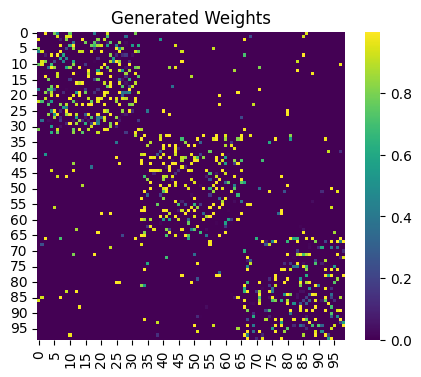

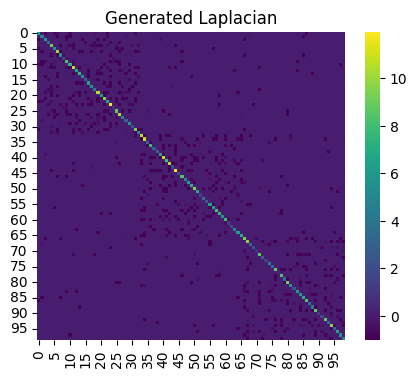

In [14]:
visualize_matrix(W.toarray(), 99, title = "Generated Weights")
visualize_matrix(L.toarray(), 99, title = "Generated Laplacian")

## Gaussian Signal Generation

In [15]:
def plot_trajectories(data, num_trajectories, figsize=(5, 3)):
    selected_points = np.random.choice(S.shape[1], size=num_trajectories, replace=False)

    plt.figure(figsize=figsize)

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', 'D', '^', 'v', '<', '>']

    for i, col in enumerate(selected_points):
        plt.plot(
            data[:, col],
            color=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            markevery=5,
            linestyle='--',
            linewidth=1,
            label=f'Point {col}'
        )

    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title(f'Trajectories of {num_trajectories} Random Point(s) Over {S.shape[0]} Steps', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

In [16]:
def plot_mean_and_covariance(data, figsize=(6, 3)):
    mean_vector = data.mean(axis=0)
    covariance_matrix = np.cov(data, rowvar=False)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].plot(mean_vector, marker='o', linestyle='-')
    axes[0].set_title('Mean Values')
    axes[0].set_xlabel('Node')
    axes[0].grid(True, alpha=0.3)

    cax = axes[1].imshow(pinvh(covariance_matrix), cmap='viridis')
    axes[1].set_title('Inverse Covariance')
    fig.colorbar(cax, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

(500000, 99)


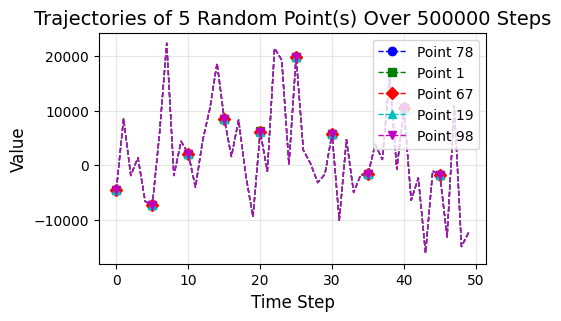

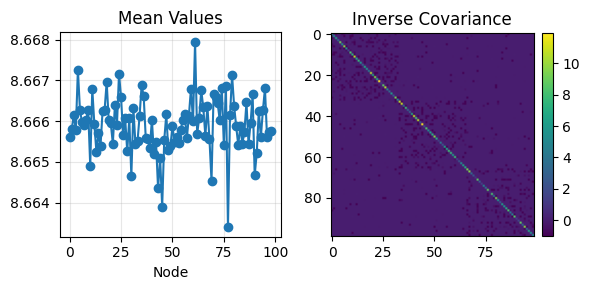

In [17]:
S = SignalGenerator(28).generate_gaussian_signal(L, 500000)
print(S.shape)
plot_trajectories(S[:50,:], 5)
plot_mean_and_covariance(S)

Generating 8 samples
Generating 16 samples
Generating 32 samples
Generating 64 samples
Generating 128 samples
Generating 256 samples
Generating 512 samples
Generating 1024 samples
Generating 2048 samples
Generating 4096 samples
Generating 8192 samples
Generating 16384 samples
Generating 32768 samples
Generating 65536 samples
Generating 131072 samples
Generating 262144 samples
Generating 524288 samples
Generating 1048576 samples
Generating 2097152 samples


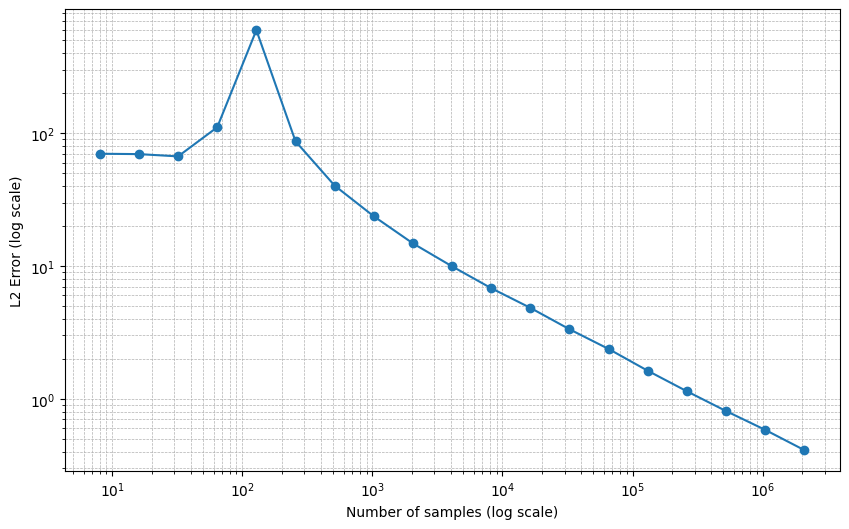

In [18]:
errors = []
x = []
L_dense = L.toarray()
for i in range(3, 22):
    n_samples = 2**i
    x.append(n_samples)
    print("Generating", n_samples, "samples")
    S = SignalGenerator(28).generate_gaussian_signal(L, n_samples, method="SG")
    cov = np.cov(S, rowvar=False)
    inv_cov = pinvh(cov)
    error = np.linalg.norm(L_dense - inv_cov, ord='fro')
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('L2 Error (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

(50000, 99)


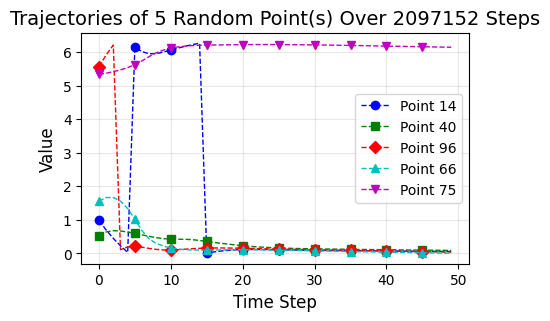

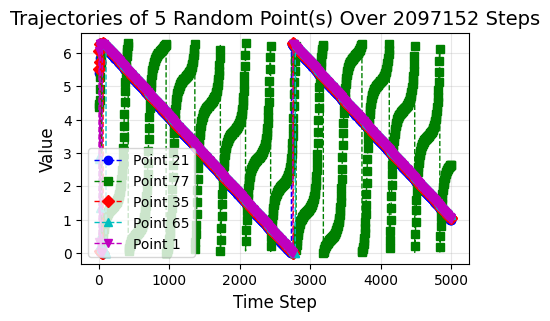

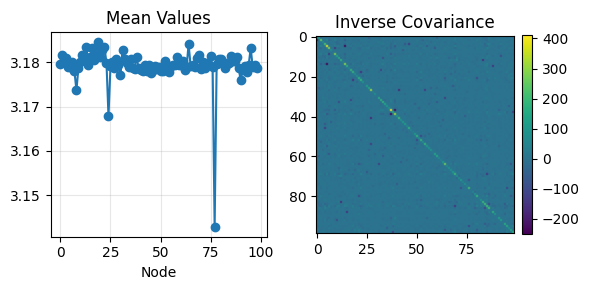

In [19]:
S_K = SignalGenerator(seed).generate_kuramoto_signal(W, 50000)
print(S_K.shape)
plot_trajectories(S_K[:50,:], 5)
plot_trajectories(S_K[:5000,:], 5)
plot_mean_and_covariance(S_K)

In the Kuramoto model, the phases of oscillators do covary based on their coupling factor:

* Positive coupling: oscillators tend to synchronize, pulling their phases closer together. These are "conformists" that are attracted to synchronize with other oscillators.
* Negative coupling: oscillators tend to desynchronize or become "contrarians", preferring phases opposite to those they're coupled with.

The absolute value of the coupling determines how strongly this attraction or repulsion occurs.

## First Inference 

Learn weights from SBM structured graph signals, with and without structure knowledge.

## First Experiment

Generate signals using the Kuramoto model, then try to apply MLE-type of learning method.

## Second Experiment

Get a first idea of how it scales with network size.

## Third Experiment

Physics based spectrum (WDS without pumps is easier parralel) vs data-based. Issue with WDS: it is not mean zero (if we look at bilan influx/outflux): source will alway negative and hydrants positive. Would it make sense in this case to recenter?

Also with flux, we get structural case where, for a source giving to two other nodes, means they will share similar patterns but with different scales, leading to higher distance, although direct, strong edge. But it makes sense because if the source was only giving to one node then they should be the same order, then stronger relation between the 2.

Problem of directionality with WDS? Can we still apply our network inference?

In terms of narrative maybe sensor network, e.g. water quality in WDS.